# Lab 11 (Evaluable)

### Imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from random import seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
#from xgboost import XGBRegressor
import lightgbm as lgb
import pickle

import warnings
warnings.simplefilter('ignore')

sns.set_palette("icefire")

### Read the Data

In [39]:
# Cargar CSV según estructura proporcionada
df = pd.read_csv("student_management_dataset.csv", encoding="utf-8", sep=",")

# Guardar cantidad de filas originales
original_rows = df.shape[0]
original_rows

1000

In [40]:
# Mostrar primeras 3 filas
df.head(3)

Student_ID  Age  Gender Ethnicity Socioeconomic_Status  \
0           1   24  Female  Hispanic               Medium   
1           2   21  Female     Asian                  Low   
2           3   28    Male     Black               Medium   

  Parental_Education_Level  Disability_Status   GPA Past_Academic_Performance  \
0                 Master’s                  0  3.26             Above Average   
1              High School                  0  2.04             Below Average   
2               Bachelor’s                  0  2.42                   Average   

   Current_Semester_Performance  ...  Attendance_Rate  \
0                            90  ...        62.150096   
1                            78  ...        89.773096   
2                            96  ...        52.481231   

   Number_of_Late_Submissions  Class_Participation_Score  \
0                           3                   9.465024   
1                           1                   2.465213   
2                           1                   8.030946   

   Online_Learning_Hours  Library_Usage_Hours  Disciplinary_Actions  \
0              15.168495             5.803625                     1   
1               4.112098            10.242415                     0   
2              10.885028            13.461105                     1   

   Social_Engagement_Score  Mental_Health_Score  Extracurricular_Activities  \
0                 8.128234             1.703851                           2   
1                 5.869194             2.094571                           3   
2                 7.606479             7.959876                           0   

   Dropout_Risk  
0             0  
1             0  
2             0  

[3 rows x 23 columns]

## Data Gathering and Data Wrangling

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    1000 non-null   int64  
 1   Age                           1000 non-null   int64  
 2   Gender                        1000 non-null   object 
 3   Ethnicity                     1000 non-null   object 
 4   Socioeconomic_Status          1000 non-null   object 
 5   Parental_Education_Level      1000 non-null   object 
 6   Disability_Status             1000 non-null   int64  
 7   GPA                           1000 non-null   float64
 8   Past_Academic_Performance     1000 non-null   object 
 9   Current_Semester_Performance  1000 non-null   int64  
 10  Courses_Failed                1000 non-null   int64  
 11  Credits_Completed             1000 non-null   int64  
 12  Study_Hours_per_Week          1000 non-null   int64  
 13  Atte

In [42]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    1000 non-null   int64  
 1   Age                           1000 non-null   int64  
 2   Gender                        1000 non-null   object 
 3   Ethnicity                     1000 non-null   object 
 4   Socioeconomic_Status          1000 non-null   object 
 5   Parental_Education_Level      1000 non-null   object 
 6   Disability_Status             1000 non-null   int64  
 7   GPA                           1000 non-null   float64
 8   Past_Academic_Performance     1000 non-null   object 
 9   Current_Semester_Performance  1000 non-null   int64  
 10  Courses_Failed                1000 non-null   int64  
 11  Credits_Completed             1000 non-null   int64  
 12  Study_Hours_per_Week          1000 non-null   int64  
 13  Atte

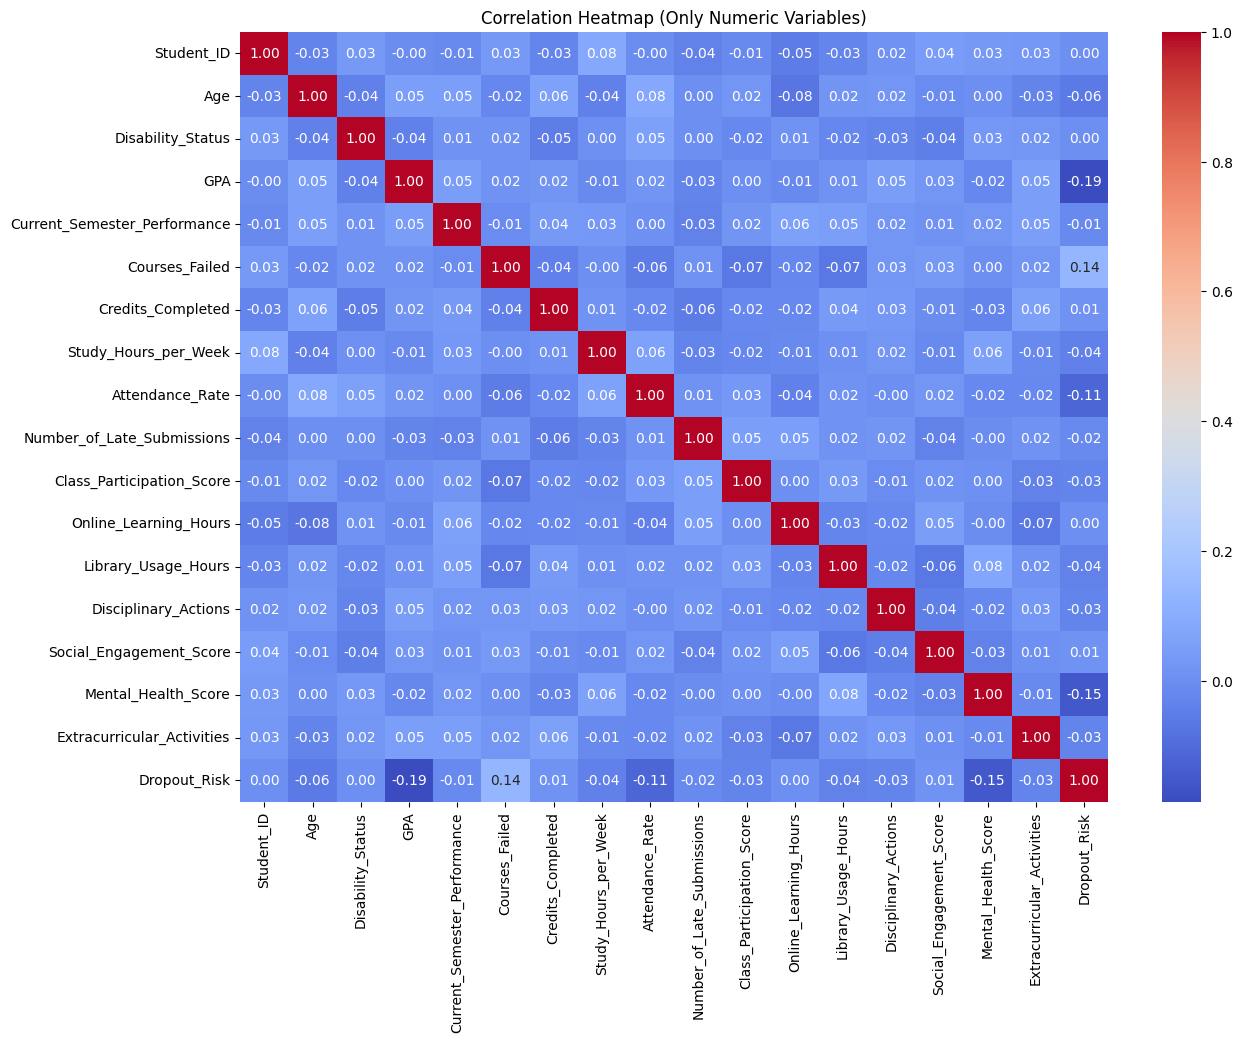

In [43]:
# Seleccionar solo columnas numéricas
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Only Numeric Variables)")
plt.show()


¿Influye el número de horas de estudio en el rendimiento del semestre?

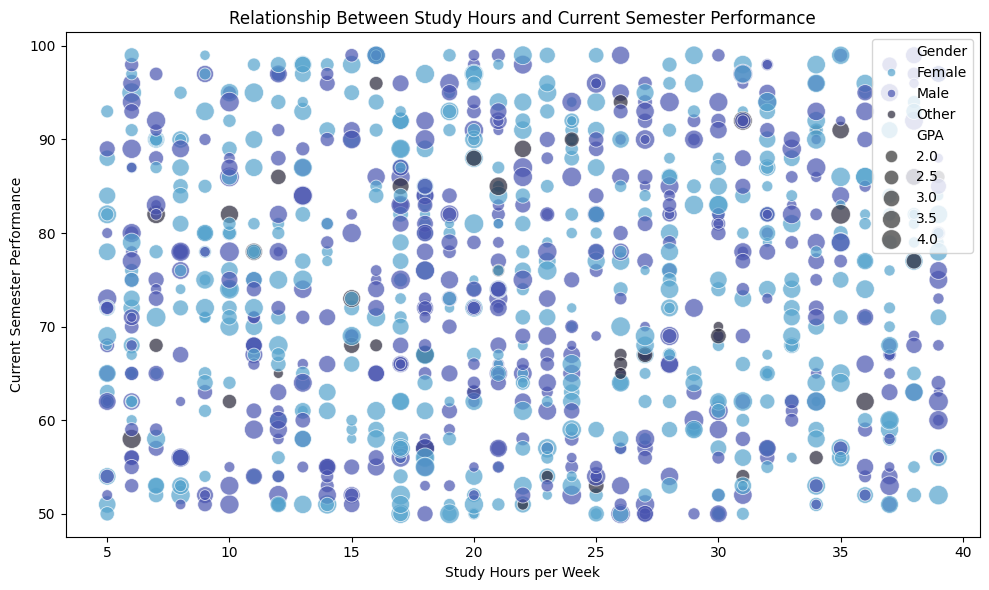

In [44]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x="Study_Hours_per_Week",
    y="Current_Semester_Performance",
    hue="Gender",           # Para colorear por género
    size="GPA",             # Tamaño del punto según GPA
    sizes=(50, 200),
    alpha=0.7
)

plt.title("Relationship Between Study Hours and Current Semester Performance")
plt.xlabel("Study Hours per Week")
plt.ylabel("Current Semester Performance")
plt.tight_layout()
plt.show()


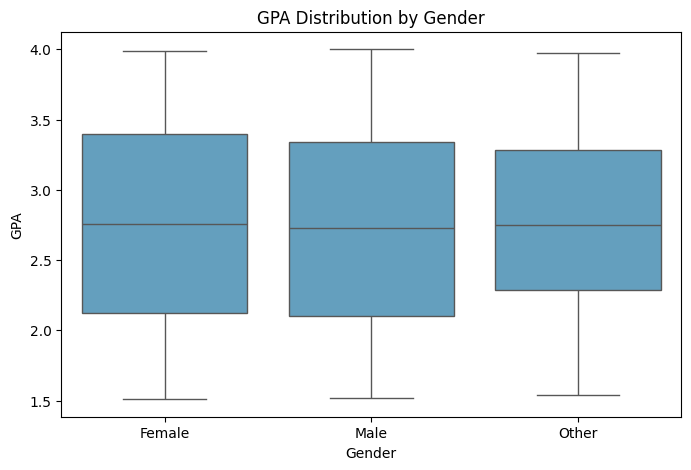

In [45]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Gender", y="GPA")
plt.title("GPA Distribution by Gender")
plt.show()


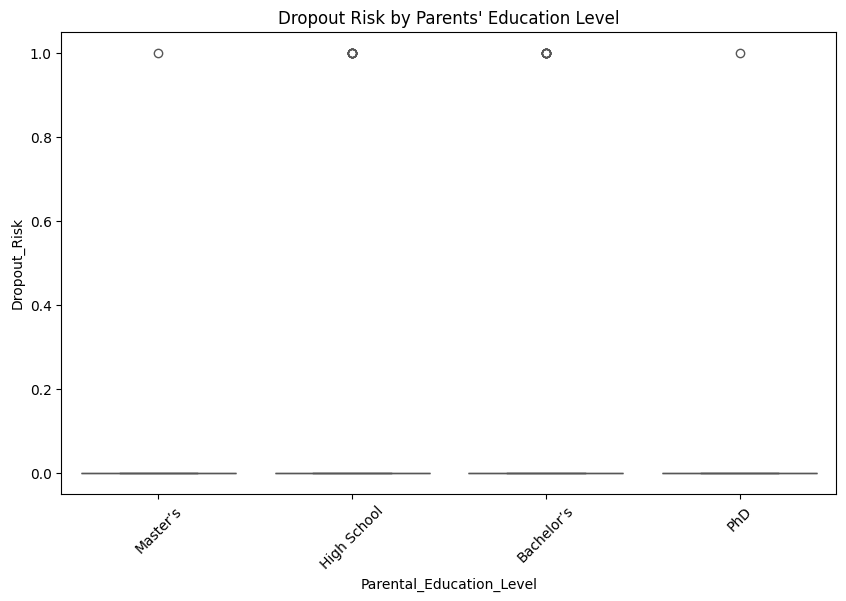

In [46]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Parental_Education_Level", y="Dropout_Risk")
plt.title("Dropout Risk by Parents' Education Level")
plt.xticks(rotation=45)
plt.show()


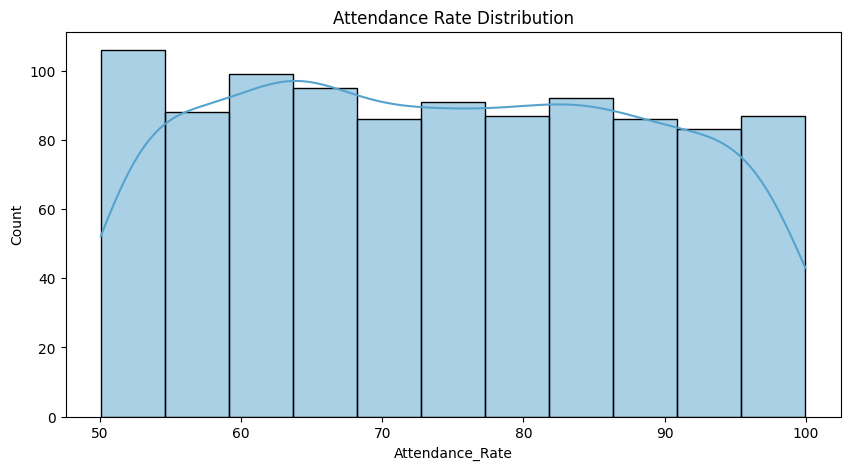

In [47]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Attendance_Rate"], kde=True)
plt.title("Attendance Rate Distribution")
plt.show()


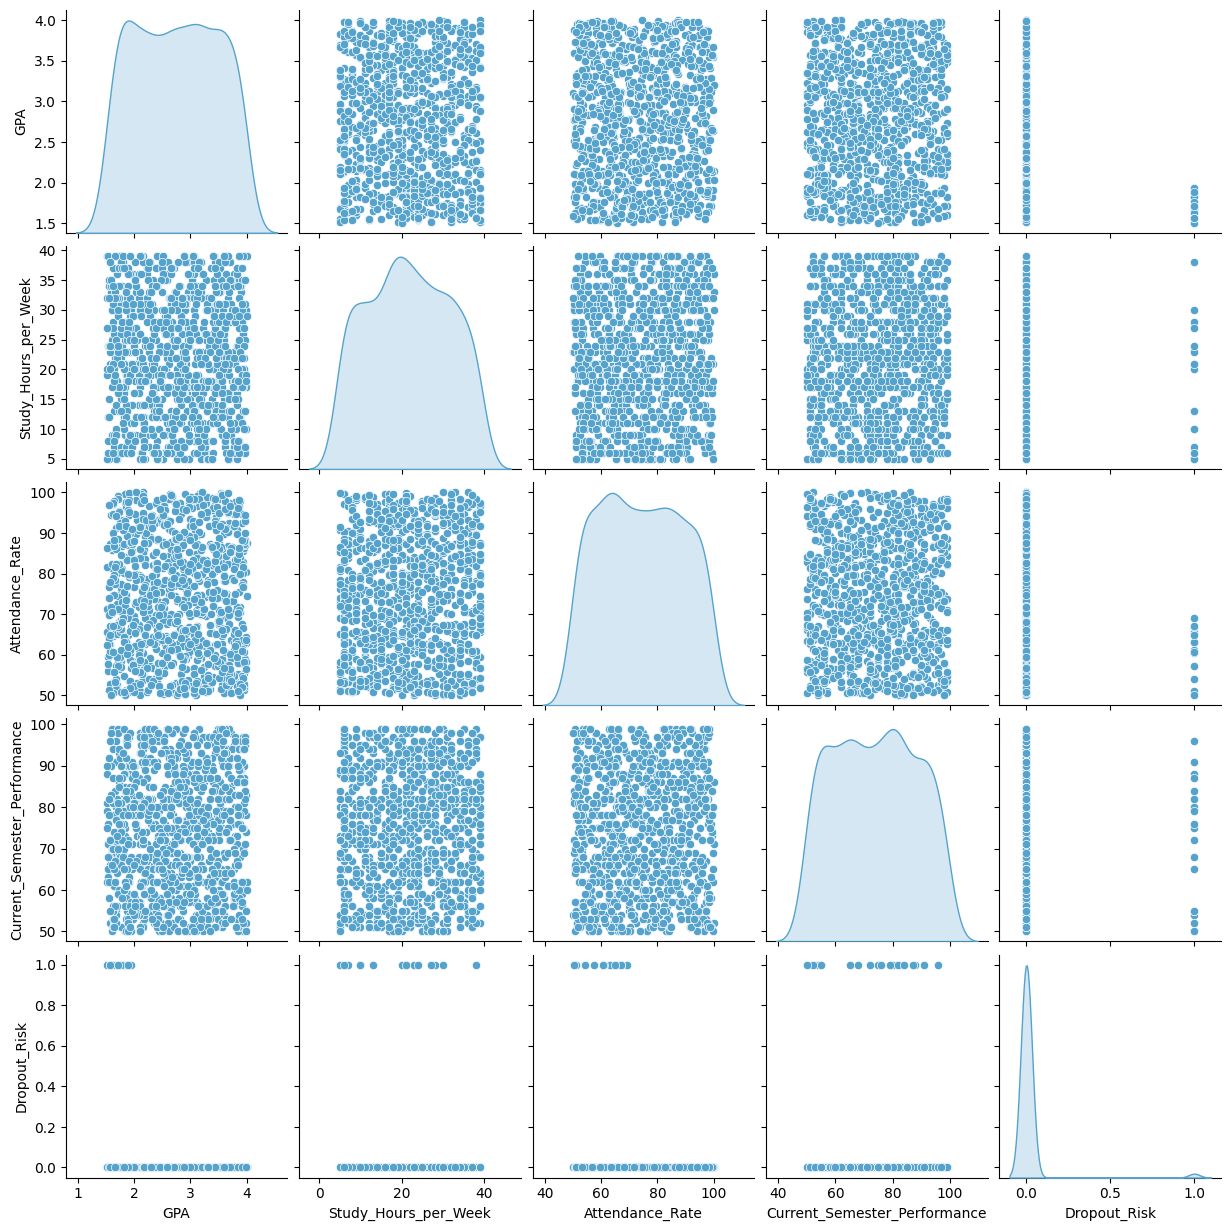

In [48]:
sns.pairplot(df[[
    "GPA",
    "Study_Hours_per_Week",
    "Attendance_Rate",
    "Current_Semester_Performance",
    "Dropout_Risk"
]], diag_kind="kde")
plt.show()


#### Let's analyze each variable distribution (except for car and model)

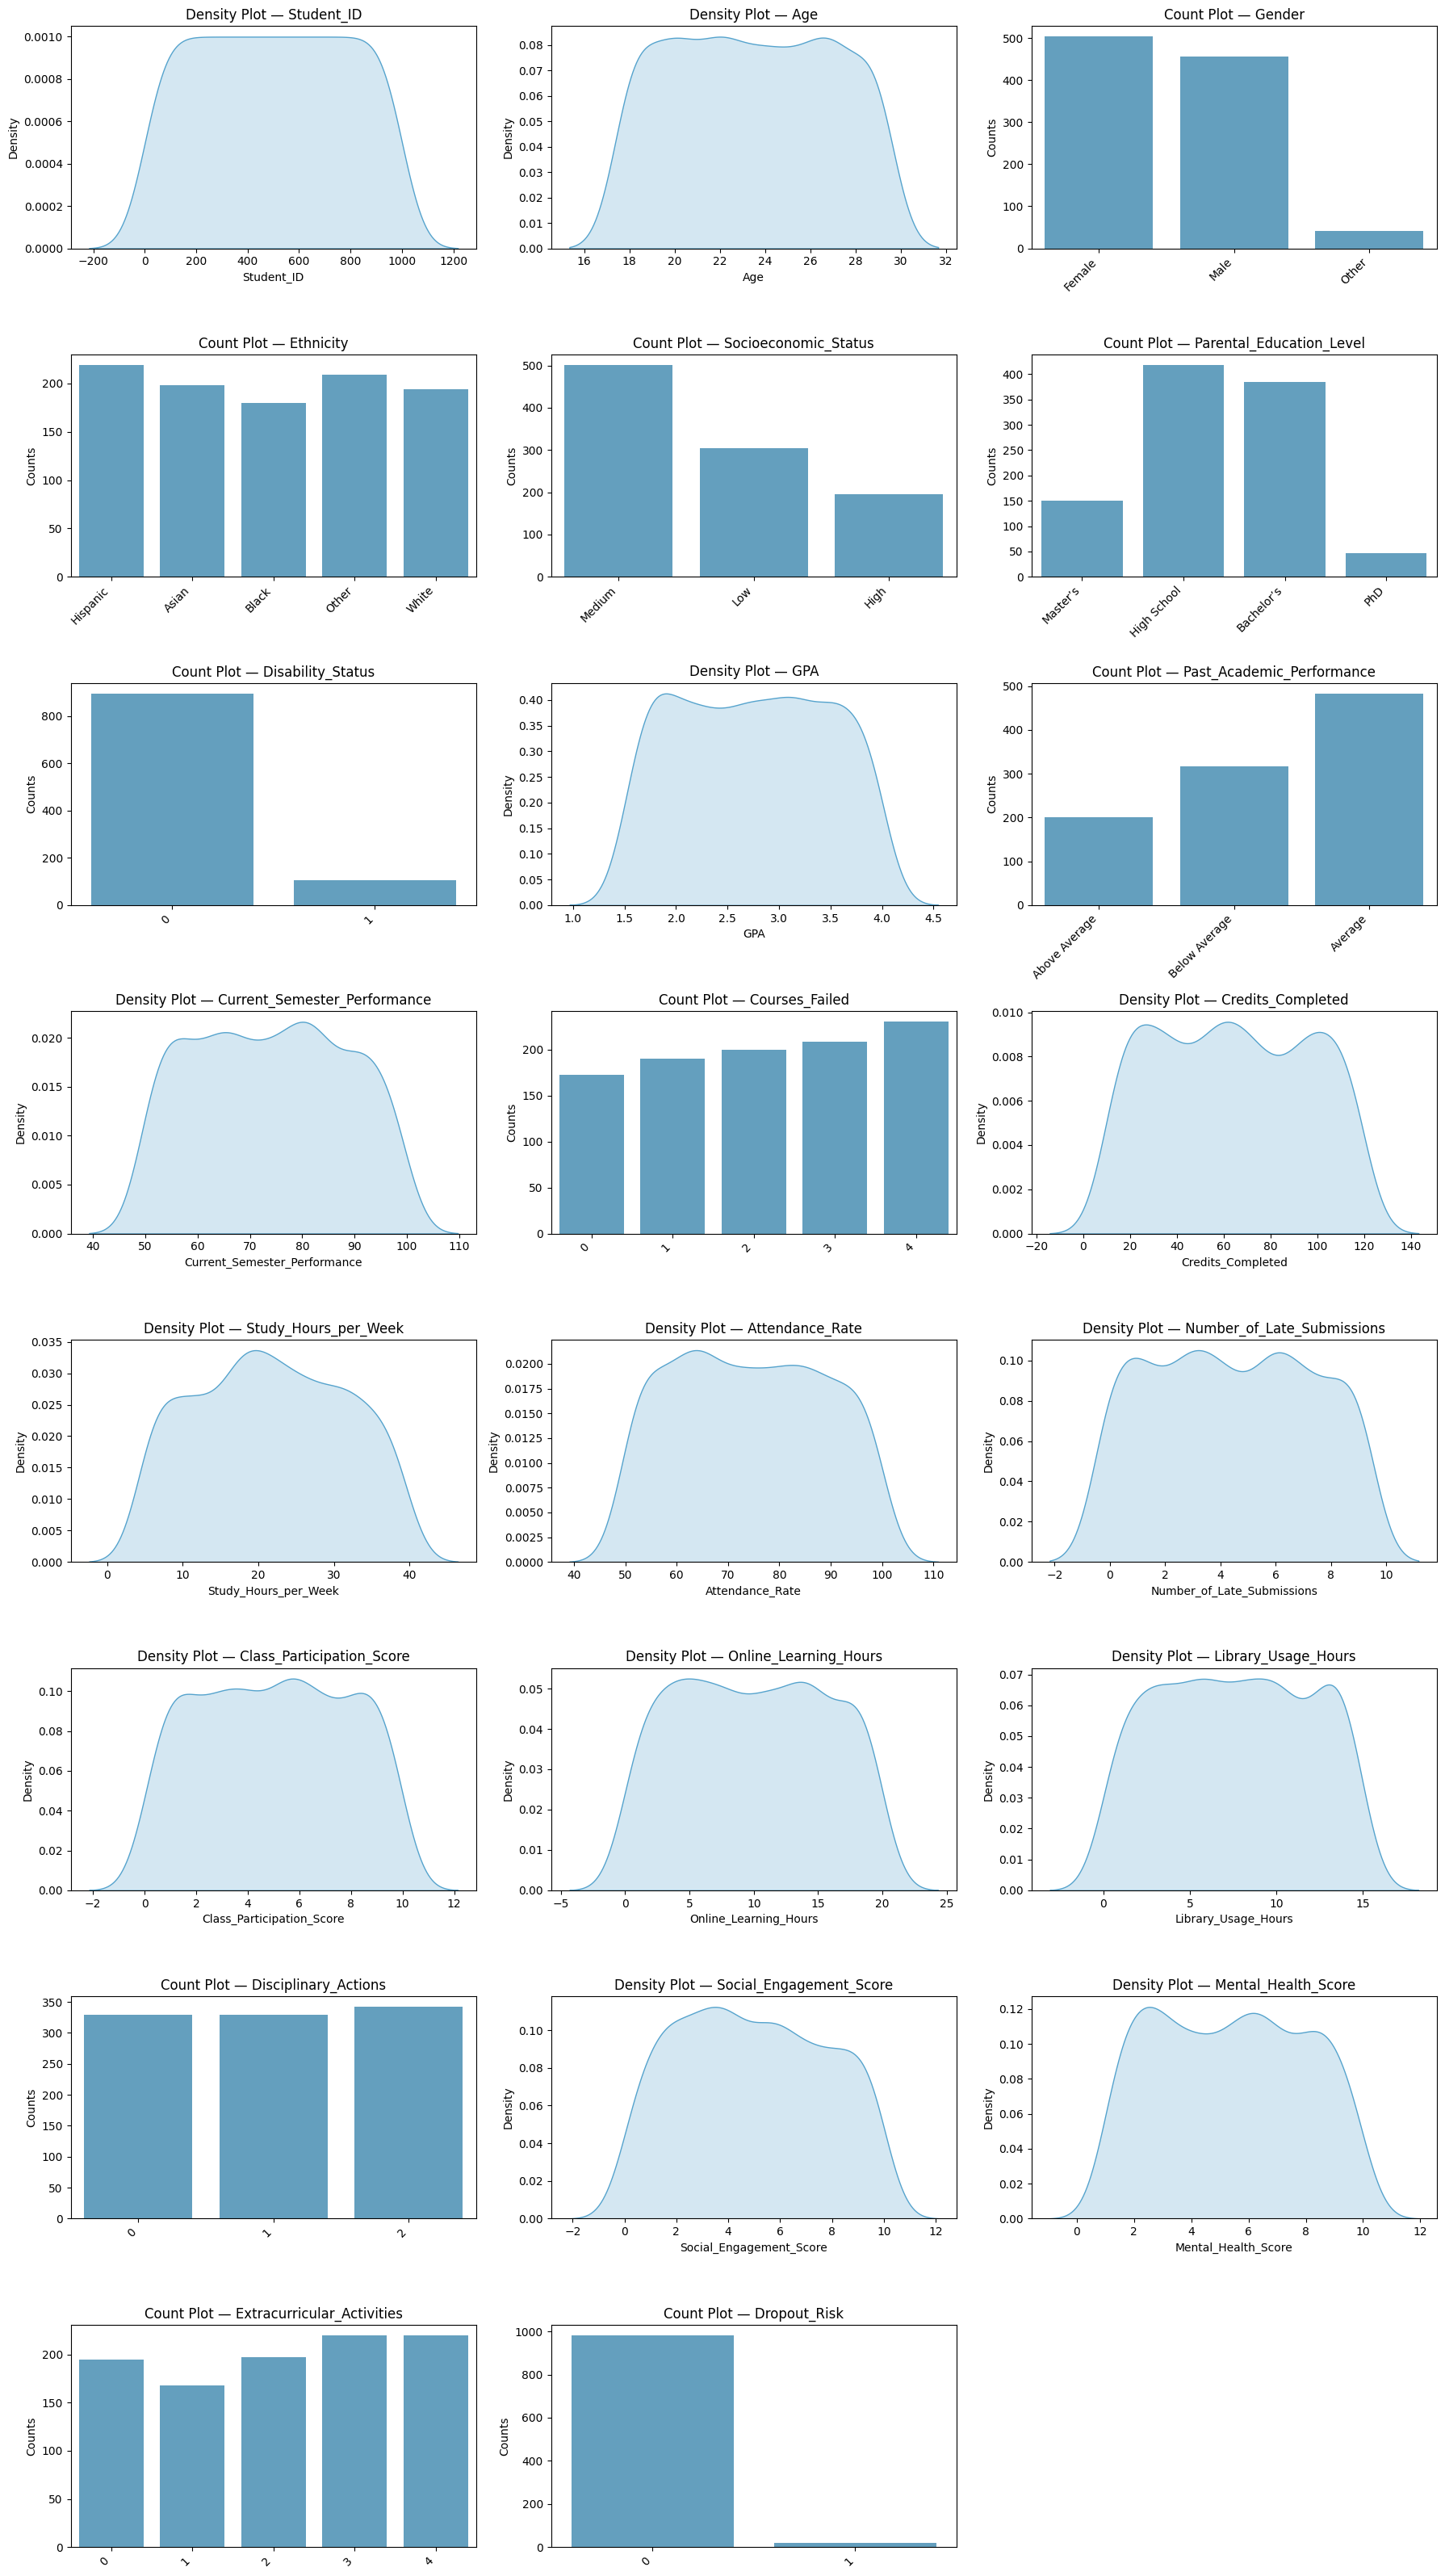

In [49]:
plot_types = {}
columns = df.columns  # todas las columnas del dataset

for col in columns:
    if df[col].dtype == 'object':  # Categóricas
        plot_types[col] = 'bar'

    else:  # Numéricas
        unique_values = df[col].nunique()

        if unique_values < 10:
            plot_types[col] = 'bar'      # Discretas
        else:
            plot_types[col] = 'kde'      # Continuas

# Layout
n_cols = 3
n_rows = (len(columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

# Crear cada plot
for i, col in enumerate(columns):
    ax = axes[i]

    if plot_types[col] == 'bar':
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(f'Count Plot — {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Counts')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    else:  # kde plot
        sns.kdeplot(df[col], ax=ax, fill=True)
        ax.set_title(f'Density Plot — {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')

# Ocultar subplots vacíos
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


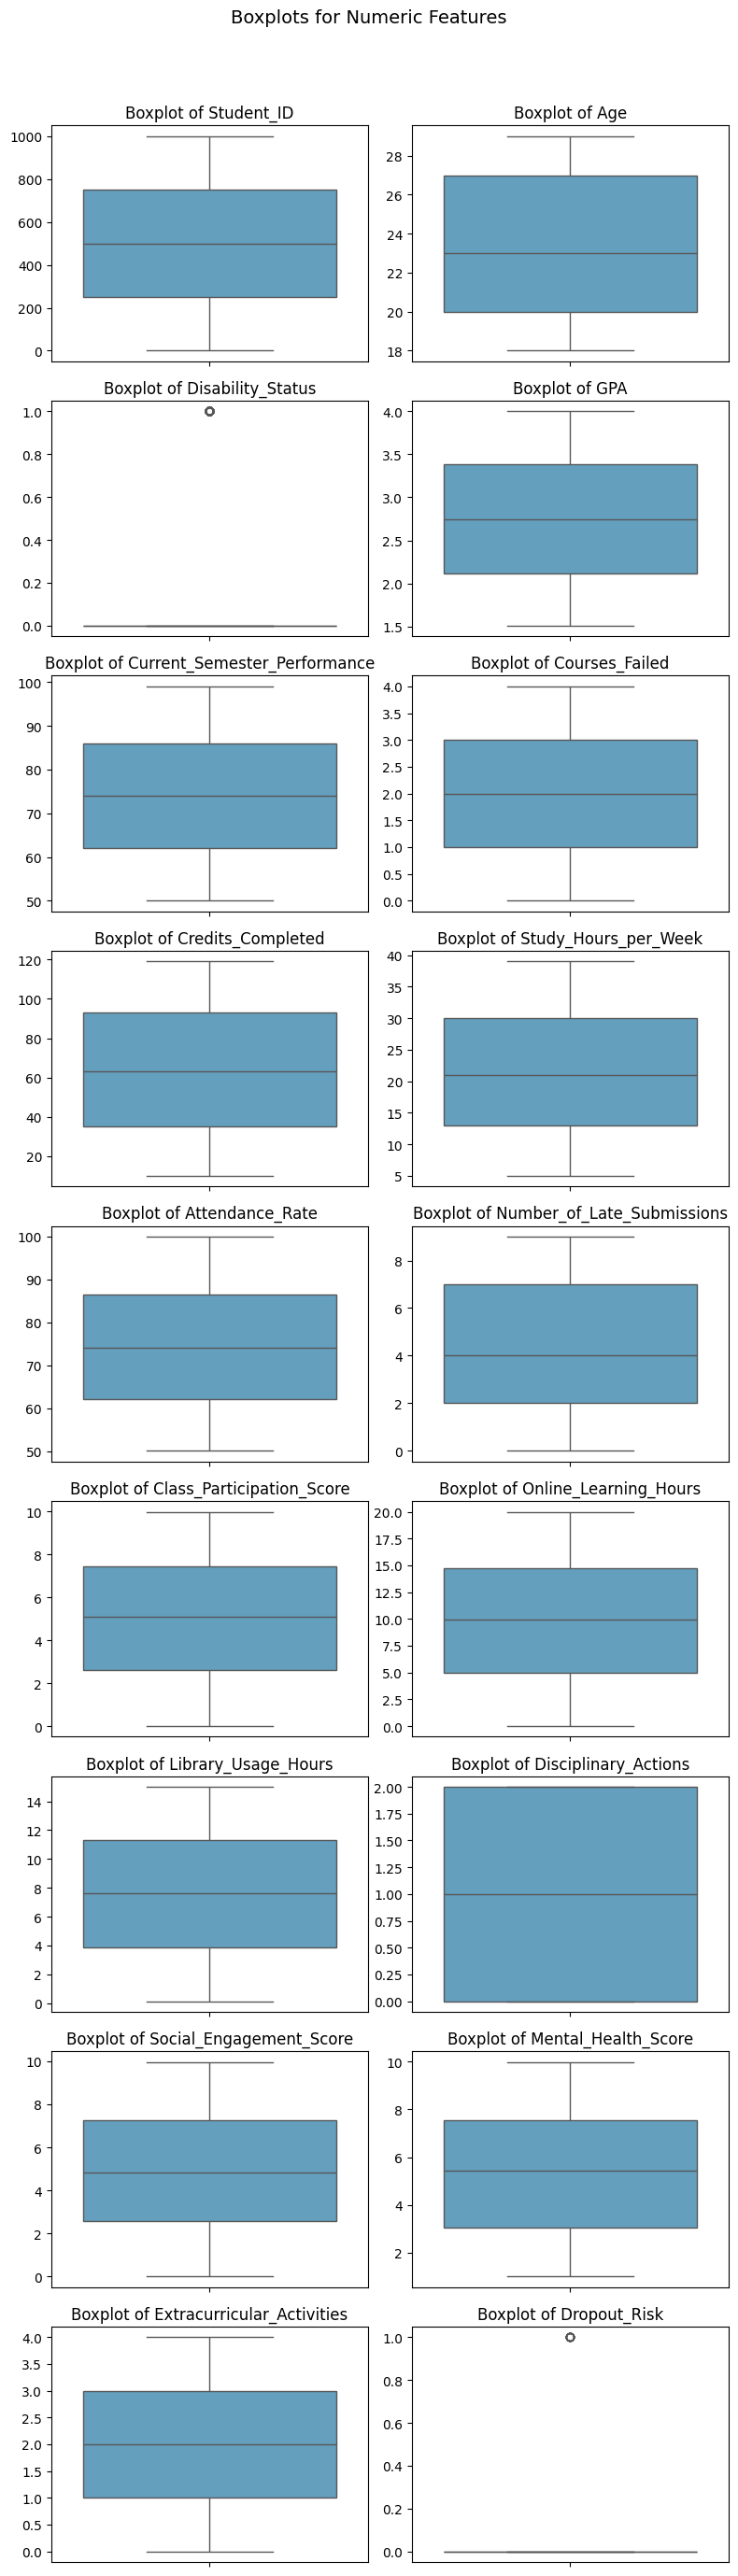

In [50]:
numeric_columns = df.select_dtypes(include=['number']).columns

n_cols = 2
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Ocultar los subplots sobrantes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots for Numeric Features", fontsize=14, y=1.02)
fig.tight_layout()
plt.show()


In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Estatus Socioeconómico vs GPA
sns.boxplot(ax=axes[0], x="Socioeconomic_Status", y="GPA", data=df, palette="icefire")
axes[0].set_title("Influencia del Estatus Socioeconómico en el GPA")

# Gráfico 2: Educación de los padres vs GPA
sns.boxplot(ax=axes[1], x="Parental_Education_Level", y="GPA", data=df, palette="icefire")
axes[1].tick_params(axis='x', rotation=45) # Rotamos etiquetas para leer mejor
axes[1].set_title("Influencia de la Educación Parental en el GPA")

plt.tight_layout()
plt.show()

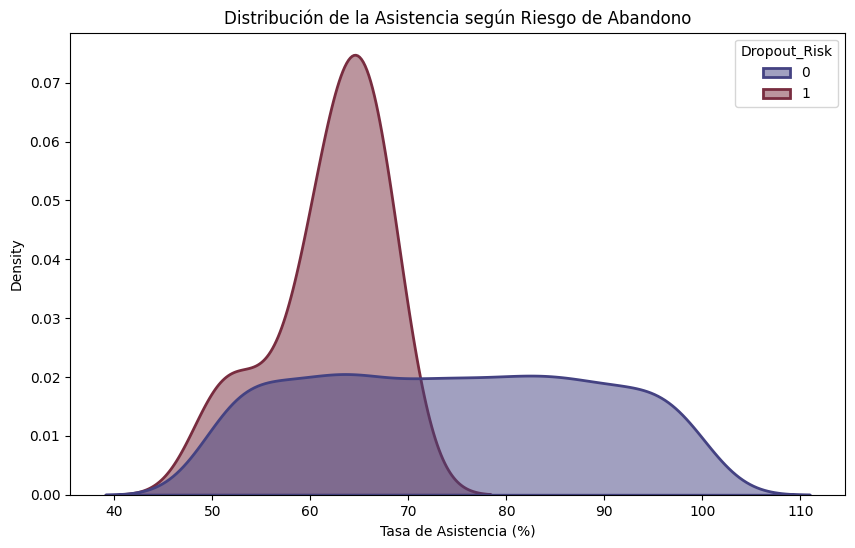

In [52]:
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df, 
    x="Attendance_Rate", 
    hue="Dropout_Risk", 
    fill=True, 
    common_norm=False, 
    palette="icefire",
    alpha=0.5,
    linewidth=2
)

plt.title("Distribución de la Asistencia según Riesgo de Abandono")
plt.xlabel("Tasa de Asistencia (%)")
plt.show()

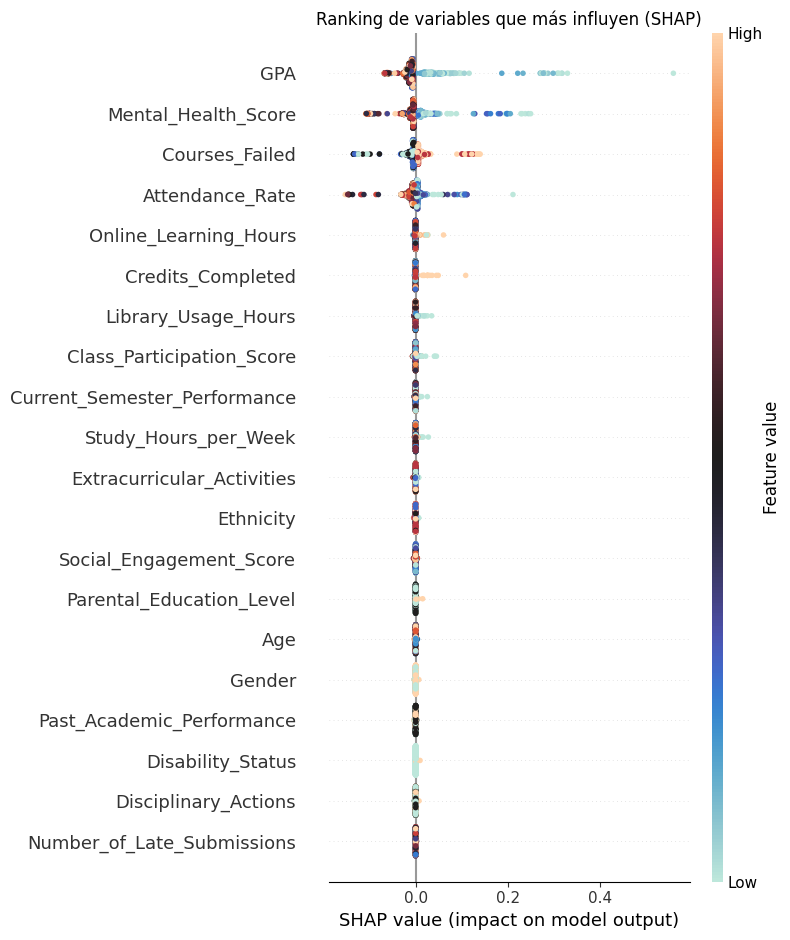

In [53]:
import shap

df_encoded = df.copy()
le = LabelEncoder()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

X = df_encoded.drop(['Student_ID', 'Dropout_Risk'], axis=1) # Variables
y = df_encoded['Dropout_Risk']                                # Objetivo

# 2. Entrenamos modelo
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X, y)

# 3. Calculamos SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 4. Graficamos el Beeswarm Plot (El gráfico más famoso de SHAP)
plt.title("Ranking de variables que más influyen (SHAP)")
shap.summary_plot(shap_values, X, plot_type="dot", cmap="icefire")

#### Let's analyze each variable behaviour with respect to the target (price)

In [54]:
target = "Dropout_Risk"   # cambia esto si quieres otra variable
exclude = [target, "Student_ID"]  # columnas que no deben usarse como features

features = [c for c in df.columns if c not in exclude]

n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Categóricas o numéricas discretas
    if df[feature].dtype == "object" or df[feature].nunique() < 8:
        sns.boxplot(x=feature, y=target, data=df, ax=ax)
    else:
        sns.scatterplot(x=feature, y=target, data=df, ax=ax)

    ax.set_title(f'{feature} vs {target}')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Eliminar subplots vacíos
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


**Solution:** 

### Let's prepare the data for model:

In [55]:
df_original = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    1000 non-null   int64  
 1   Age                           1000 non-null   int64  
 2   Gender                        1000 non-null   object 
 3   Ethnicity                     1000 non-null   object 
 4   Socioeconomic_Status          1000 non-null   object 
 5   Parental_Education_Level      1000 non-null   object 
 6   Disability_Status             1000 non-null   int64  
 7   GPA                           1000 non-null   float64
 8   Past_Academic_Performance     1000 non-null   object 
 9   Current_Semester_Performance  1000 non-null   int64  
 10  Courses_Failed                1000 non-null   int64  
 11  Credits_Completed             1000 non-null   int64  
 12  Study_Hours_per_Week          1000 non-null   int64  
 13  Atte

In [56]:
# Crear un diccionario para guardar los codificadores
encoders = {}

# Seleccionar solo columnas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
    print(f"* {col}: {df[col].unique()}")


* Gender: [0 1 2]
* Ethnicity: [2 0 1 3 4]
* Socioeconomic_Status: [2 1 0]
* Parental_Education_Level: [2 1 0 3]
* Past_Academic_Performance: [0 2 1]


In [57]:
# Lista de valores que significan "sí"
yes_list = ['yes', 'YES', 'Yes', 'y', 'Y']

# Detectar todas las columnas tipo object
categorical_columns = df.select_dtypes(include=['object']).columns

# Iterar sobre las columnas
for col in categorical_columns:
    # Verificar si la columna contiene valores tipo yes/no
    if df[col].str.lower().isin(['yes','no']).any() or df[col].isin(yes_list).any():
        df[col] = np.where(df[col].isin(yes_list), 1, 0)
        print(f'Columna "{col}" convertida a binaria.')


In [58]:
df = df.drop(columns='Student_ID')


In [59]:
print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           1000 non-null   int64  
 1   Gender                        1000 non-null   int64  
 2   Ethnicity                     1000 non-null   int64  
 3   Socioeconomic_Status          1000 non-null   int64  
 4   Parental_Education_Level      1000 non-null   int64  
 5   Disability_Status             1000 non-null   int64  
 6   GPA                           1000 non-null   float64
 7   Past_Academic_Performance     1000 non-null   int64  
 8   Current_Semester_Performance  1000 non-null   int64  
 9   Courses_Failed                1000 non-null   int64  
 10  Credits_Completed             1000 non-null   int64  
 11  Study_Hours_per_Week          1000 non-null   int64  
 12  Attendance_Rate               1000 non-null   float64
 13  Numb

Age  Gender  Ethnicity  Socioeconomic_Status  Parental_Education_Level  \
0   24       0          2                     2                         2   
1   21       0          0                     1                         1   
2   28       1          1                     2                         0   

   Disability_Status   GPA  Past_Academic_Performance  \
0                  0  3.26                          0   
1                  0  2.04                          2   
2                  0  2.42                          1   

   Current_Semester_Performance  Courses_Failed  ...  Attendance_Rate  \
0                            90               4  ...        62.150096   
1                            78               2  ...        89.773096   
2                            96               3  ...        52.481231   

   Number_of_Late_Submissions  Class_Participation_Score  \
0                           3                   9.465024   
1                           1                   2.465213   
2                           1                   8.030946   

   Online_Learning_Hours  Library_Usage_Hours  Disciplinary_Actions  \
0              15.168495             5.803625                     1   
1               4.112098            10.242415                     0   
2              10.885028            13.461105                     1   

   Social_Engagement_Score  Mental_Health_Score  Extracurricular_Activities  \
0                 8.128234             1.703851                           2   
1                 5.869194             2.094571                           3   
2                 7.606479             7.959876                           0   

   Dropout_Risk  
0             0  
1             0  
2             0  

[3 rows x 22 columns]

#### EX6: Now that all data is in numeric data type, Plot the correlation matrix among features:

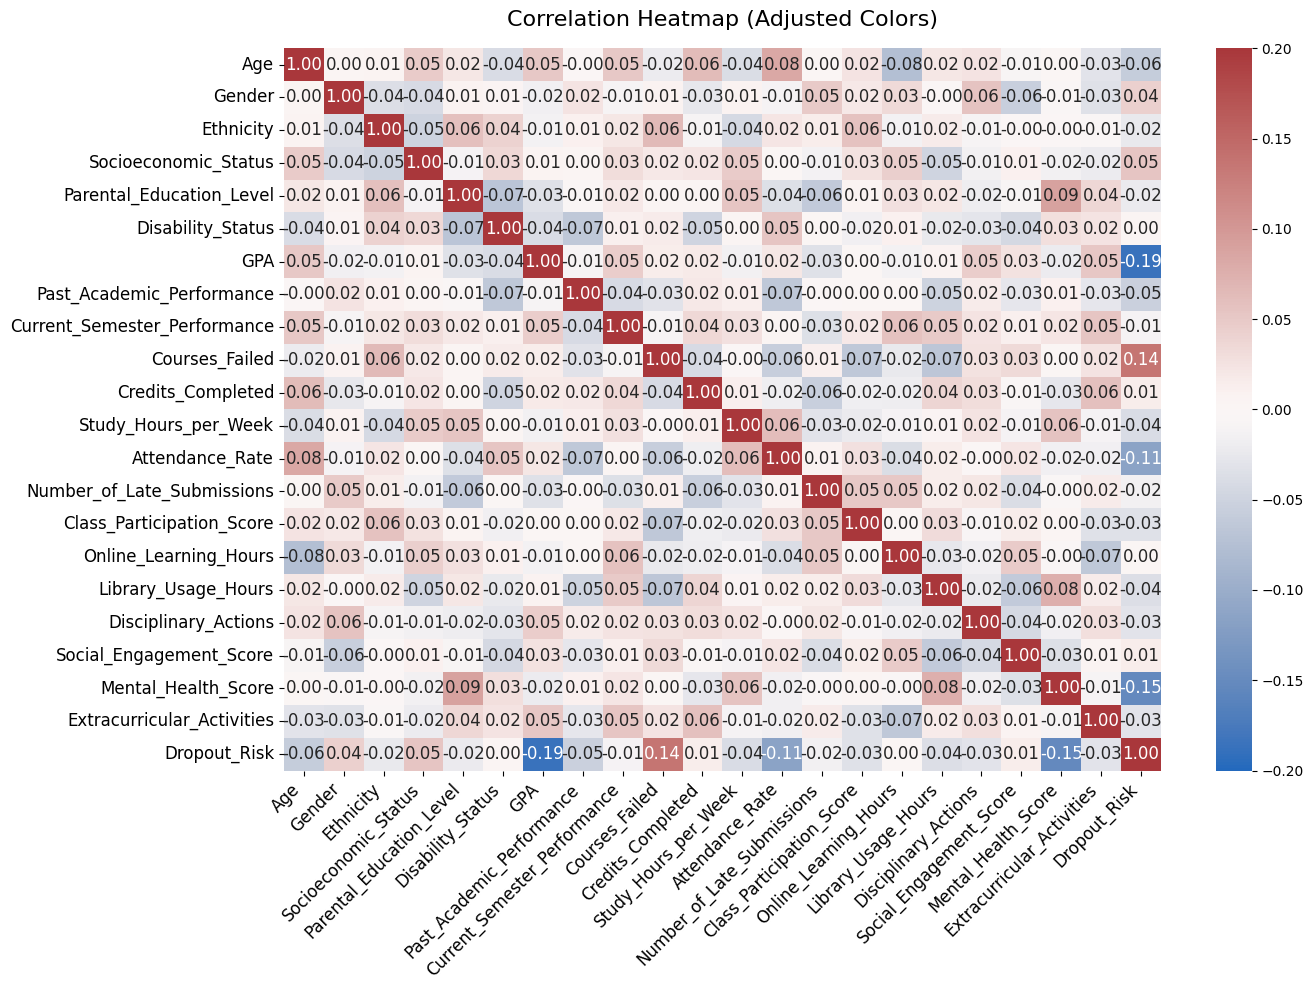

In [60]:

corr = df.corr()

# Ajustar límites según los valores reales
vmin = -0.2
vmax = 0.2

plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(
    corr, 
    vmin=vmin, vmax=vmax, 
    annot=True, 
    fmt=".2f",
    cmap='vlag',          # colormap más sutil para valores pequeños
    center=0,             # centra el color en 0
    annot_kws={"size":12}
)

heatmap.set_title('Correlation Heatmap (Adjusted Colors)', fontdict={'fontsize':16}, pad=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


#### EX7: Which variables are more correlated with the target?

**Solution:**

## Model training

In [61]:
# Variable objetivo
target = "Dropout_Risk"

# Features (todas las demás columnas excepto la target)
X = df.drop(columns=[target])
y = df[target]

# División train/test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Revisar shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (800, 21)
X_test shape: (200, 21)
y_train shape: (800,)
y_test shape: (200,)


#### Ensure X and Y have the same lenght for both train and test

In [62]:
print("Lenght X_train:",len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:",len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 800
Length y_train: 800
Lenght X_test: 200
Length y_test: 200


#### Try different models:

In [63]:
#Linear Regression:

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
display(linear_reg)

y_pred_test = linear_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

LinearRegression()

$0.12


In [64]:
#Random Forest:

random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X_train, y_train)
display(random_forest_reg)

y_pred_test = random_forest_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

RandomForestRegressor(random_state=0)

$0.04


In [65]:
#XGBoost:

lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit (X_train, y_train)
display(lgb_reg)

y_pred_test=lgb_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1955
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 21
[LightGBM] [Info] Start training from score 0.018750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMRegressor()

$0.05


#### it seems that LightGBM performs better for this use case, so let's continue with the this algorithm grid search for choosing the best parameters (this can take some minutes):

In [66]:
# Add as many parametrers as you want
max_depth = [2, 8, 12]
n_estimators = [50, 100, 300]
learning_rate = [0.1]

parameters = {
    "max_depth": max_depth,
    "n_estimators": n_estimators,
    "learning_rate": learning_rate}

lgb_reg = lgb.LGBMRegressor(random_state=42, force_row_wise=True)

# Grid Search
gs = GridSearchCV(lgb_reg, parameters, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 1681
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 21
[LightGBM] [Info] Start training from score 0.020313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

GridSearchCV(estimator=LGBMRegressor(force_row_wise=True, random_state=42),
             param_grid={'learning_rate': [0.1], 'max_depth': [2, 8, 12],
                         'n_estimators': [50, 100, 300]},
             scoring='neg_mean_squared_error')

In [67]:
lgb_reg = gs.best_estimator_
lgb_reg.fit(X_train, y_train)

y_pred_test = lgb_reg.predict(X_test)

error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

print("The R2_score is:", r2_score(y_test, y_pred_test))

[LightGBM] [Info] Total Bins 1955
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 21
[LightGBM] [Info] Start training from score 0.018750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

#### EX8: Test with an invented example (just run the code and answer the questions):

In [68]:
A = []

Q = [
    "Enter your gender " + str(list(df['Gender'].unique())) + ": ",
    "Enter your ethnicity " + str(list(df['Ethnicity'].unique())) + ": ",
    "Enter your age: ",
    "Enter your socioeconomic status " + str(list(df['Socioeconomic_Status'].unique())) + ": ",
    "Enter your parental education level " + str(list(df['Parental_Education_Level'].unique())) + ": ",
    "Enter your study hours per week: ",
    "Enter your attendance rate (0-100): ",
    "Enter your number of extracurricular activities: "
]

for q in Q:
    a = input(q)
    A.append(a)

print("Your answers are:", A)


Your answers are: ['', '', '', '', '', '', '', '']


In [69]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Crear encoders para columnas categóricas
le_Gender = LabelEncoder()
df['Gender'] = le_Gender.fit_transform(df['Gender'])

le_Ethnicity = LabelEncoder()
df['Ethnicity'] = le_Ethnicity.fit_transform(df['Ethnicity'])

le_Socioeconomic = LabelEncoder()
df['Socioeconomic_Status'] = le_Socioeconomic.fit_transform(df['Socioeconomic_Status'])

le_ParentalEdu = LabelEncoder()
df['Parental_Education_Level'] = le_ParentalEdu.fit_transform(df['Parental_Education_Level'])

# -------------------------
# Respuestas de ejemplo de un estudiante
# -------------------------
A_ex = [
    "Female",     # Gender
    "Hispanic",   # Ethnicity
    "20",         # Age
    "Medium",     # Socioeconomic_Status
    "Bachelor’s", # Parental_Education_Level
    "15",         # Study_Hours_per_Week
    "85",         # Attendance_Rate
    "2"           # Extracurricular_Activities
]

# Convertir entradas a formato compatible con encoder
A_ex_fixed = [
    A_ex[0].strip(),   # Gender
    A_ex[1].strip(),   # Ethnicity
    A_ex[2],           # Age
    A_ex[3].strip(),   # Socioeconomic_Status
    A_ex[4].strip(),   # Parental_Education_Level
    A_ex[5],           # Study_Hours_per_Week
    A_ex[6],           # Attendance_Rate
    A_ex[7]            # Extracurricular_Activities
]

# Transformar solo si existe en encoder
try:
    X_sample = [
        le_Gender.transform([A_ex_fixed[0]])[0],
        le_Ethnicity.transform([A_ex_fixed[1]])[0],
        int(A_ex_fixed[2]),
        le_Socioeconomic.transform([A_ex_fixed[3]])[0],
        le_ParentalEdu.transform([A_ex_fixed[4]])[0],
        float(A_ex_fixed[5]),
        float(A_ex_fixed[6]),
        int(A_ex_fixed[7])
    ]
except ValueError as e:
    print("Error de transformación:", e)
    print("Verifica que las entradas coincidan con las clases de cada LabelEncoder")


Error de transformación: invalid literal for int() with base 10: np.str_('Female')
Verifica que las entradas coincidan con las clases de cada LabelEncoder


In [70]:
A_ex = [
    "Female",             # Gender
    "Hispanic",           # Ethnicity
    "20",                 # Age
    "Medium",             # Socioeconomic_Status
    "Bachelor’s",         # Parental_Education_Level
    "15",                 # Study_Hours_per_Week
    "85",                 # Attendance_Rate
    "2"                   # Extracurricular_Activities
]


# Convertimos a numpy array para procesamiento
X_sample = np.array([A_ex])

# Aplicar LabelEncoder a las columnas categóricas
X_sample[:, 0] = le_Gender.transform(X_sample[:, 0])
X_sample[:, 1] = le_Ethnicity.transform(X_sample[:, 1])
X_sample[:, 3] = le_Socioeconomic.transform(X_sample[:, 3])
X_sample[:, 4] = le_ParentalEdu.transform(X_sample[:, 4])

# Convertir las columnas numéricas a int/float
X_sample = np.array([[
    int(X_sample[0, 0]),                  # Gender
    int(X_sample[0, 1]),                  # Ethnicity
    int(X_sample[0, 2]),                  # Age
    int(X_sample[0, 3]),                  # Socioeconomic_Status
    int(X_sample[0, 4]),                  # Parental_Education_Level
    float(X_sample[0, 5]),                # Study_Hours_per_Week
    float(X_sample[0, 6]),                # Attendance_Rate
    int(X_sample[0, 7])                   # Extracurricular_Activities
]])

print("The encoded array is:", X_sample)

ValueError: invalid literal for int() with base 10: np.str_('Female')

In [ ]:
y_pred_sample = lgb_reg.predict(X_sample)
print("Your car estimated price is: ","${:,.02f}".format(y_pred_sample[0]))

Your car estimated price is:  $25,904.50


### Store and read the model

In [ ]:
# Store
data = {"model": lgb_reg, "le_car": le_car, "le_body": le_body, "le_engType":le_engType , "le_drive":le_drive}
with open('model.pkl', 'wb') as file:
    pickle.dump(data, file)

In [ ]:
# Read
with open('model.pkl', 'rb') as file:
    data = pickle.load(file)

model = data["model"]
le_car = data["le_car"]
le_body = data["le_body"]
le_engType = data["le_engType"]
le_drive = data["le_drive"]

y_pred_sample = model.predict(X_sample)
print("Your car estimated price is: ","${:,.02f}".format(y_pred_sample[0]))

Your car estimated price is:  $25,904.50


## Explainability AI

As an excellent data scientist, we cannot conclude our work without understanding how the model works. In this section of the project, we will apply SHAP as a technique to understand, debug and explain our model.

### Global explainability

#### EX9: Train a Shap explainer and calculate the shap_values object for the X_test dataset. Print the shap values object of the first sample of X_test.

In [ ]:
# CODE HERE

import shap
shap.initjs()
explainer = shap.Explainer(lgb_reg, X_train)
shap_values = explainer(X_test)

display(X_test)
print(shap_values[0])

car  body  mileage  engV  engType  registration  year  drive
4768   27     2      350   1.8        3             1  1990      0
7720   26     1      140   1.7        1             1  2007      0
4300   29     3      285   1.6        3             1  2001      0
8408   12     5      110   1.9        0             1  2008      0
2919   43     3      330   2.8        1             1  1994      0
...   ...   ...      ...   ...      ...           ...   ...    ...
3776   35     1       91   1.8        3             1  2011      0
7335   43     2       10   1.6        0             1  1984      2
5725   43     3      102   1.8        3             1  2011      0
4667    3     3      400   2.8        3             1  1998      2
8640   42     3        5   1.6        3             1  2007      2

[2056 rows x 8 columns]

.values =
array([ -301.37632308,  -106.83672633,  -666.20256309,  -244.91473192,
          74.90739225,    47.7806849 , -7419.19664168,  -377.40466124])

.base_values =
np.float64(11974.468337506503)

.data =
array([2.70e+01, 2.00e+00, 3.50e+02, 1.80e+00, 3.00e+00, 1.00e+00,
       1.99e+03, 0.00e+00])


#### EX10: Which is the average price cost prediction for all cars?

**Solution:**

#### Let's plot the summary plot and bar plot for global explainability of the model.

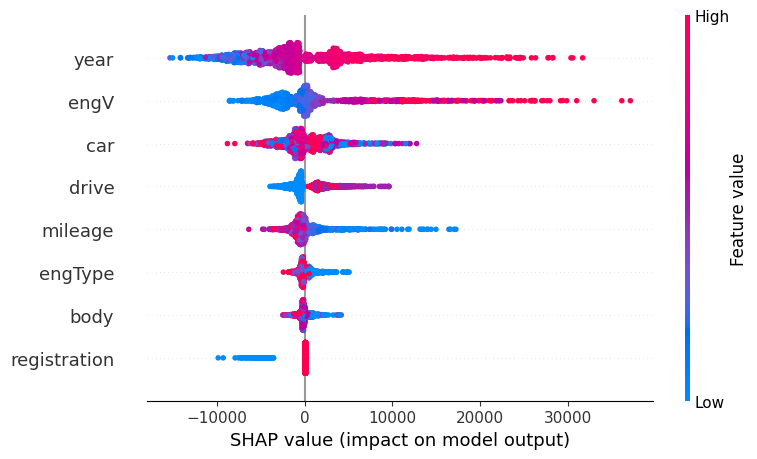

In [ ]:
#Global Explainability
shap.summary_plot(shap_values, X_test)

In [ ]:
#Plot var: built from column 1 of all shap_values
shap.plots.bar(shap_values)

#### EX11: Which are your insights?

**Solution:**

#### Let's do deep dive in the variables `Mileage`, `engV` and `year`. 

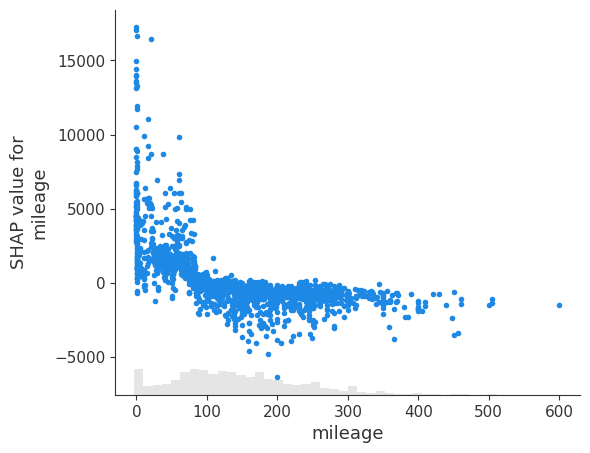

In [ ]:
shap.plots.scatter(shap_values[:,"mileage"])

In [ ]:
shap.plots.scatter(shap_values[:,"engV"])

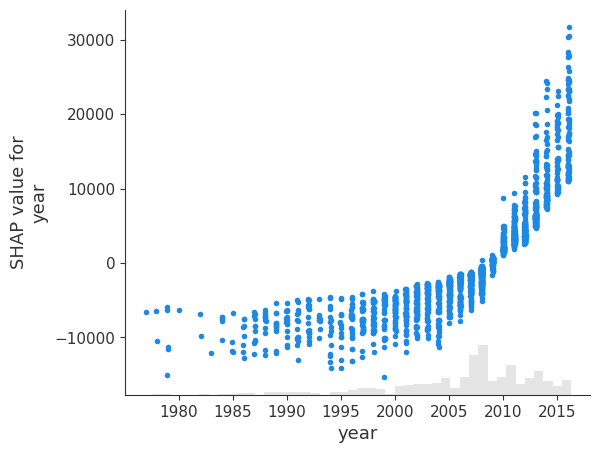

In [ ]:
shap.plots.scatter(shap_values[:,"year"])

#### EX12: What are the most relevant insights abour the evolution of the features' values and their Shap values.

#### **Solution:**

#### Let's analyze the relationship of the variables `engV` and `year` and their Shap values according to the value of `mileage`.

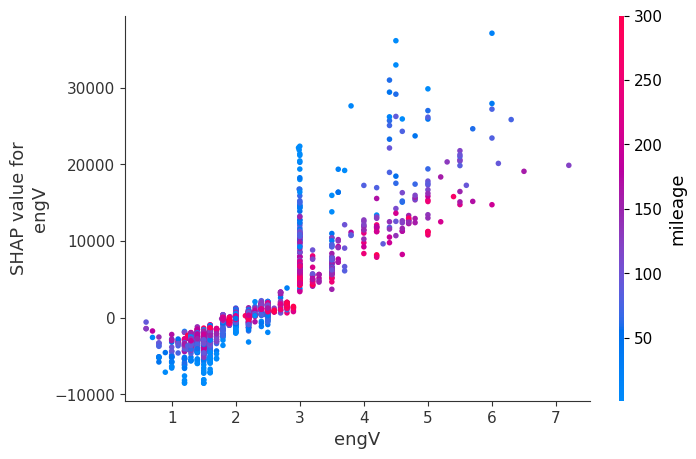

In [ ]:
#Let's analyze the evolution of Shap values of engV based on mileage
shap.dependence_plot("engV", shap_values.values, X_test, interaction_index= "mileage")

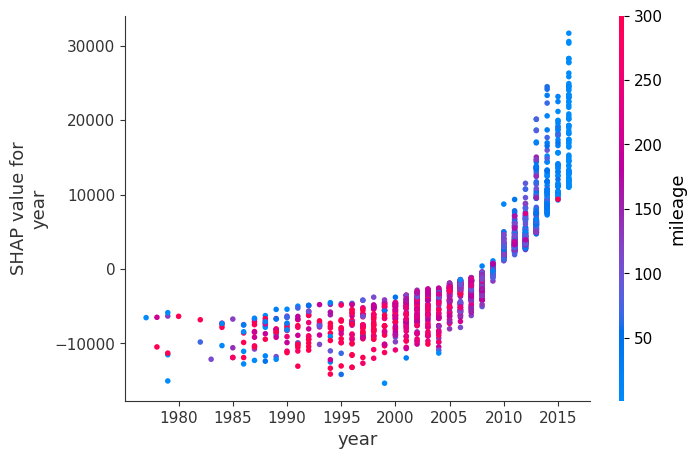

In [ ]:
#Let's analyze the evolution of Shap values of engV based on mileage
shap.dependence_plot("year", shap_values.values, X_test, interaction_index= "mileage")

 #### EX13: What are the most relevant insights about the evolution of the features' values and their Shap values.

**Solution:**

### Local explainability

Local explainability facilitates the understanding of the prediction for some particular cases. In other words, XAI closes to a personalized prediction explainability. Let's use the first sample of X_test for the following steps.

#### Using the waterfall, force and decision plots, we can explain how the model works.

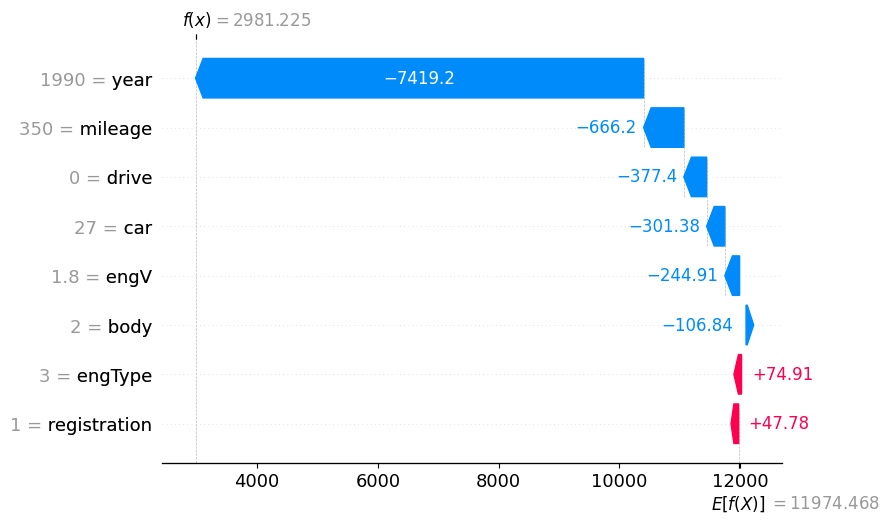

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.force(shap_values[0])

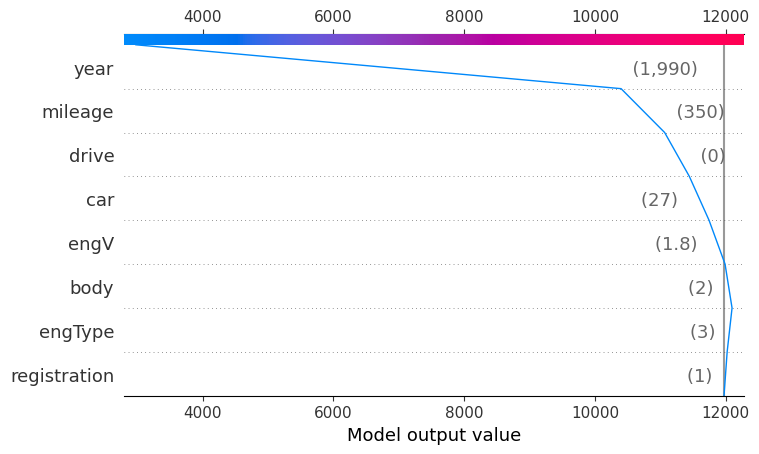

In [ ]:
shap.decision_plot(shap_values[0].base_values,shap_values[0].values, X_test.iloc[0])